In [1]:
!pwd

/home/kevin


In [1]:
import ray

In [2]:
ray.init()

2023-12-11 03:13:14,507	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.11
Ray version:,2.8.1
Dashboard:,http://127.0.0.1:8265


In [3]:
ray.available_resources()

{'CPU': 12.0,
 'node:__internal_head__': 1.0,
 'node:127.0.0.1': 1.0,
 'memory': 2785849344.0,
 'GPU': 1.0,
 'object_store_memory': 1392924672.0}

In [6]:
%cd d:/dev/TranAD
!pwd

d:\dev\TranAD


'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import json
from src.folderconstants import *
from shutil import copyfile
from sklearn import preprocessing
import matplotlib.pyplot as plt
from settings import *
dataset_folder = 'data/addr1394'

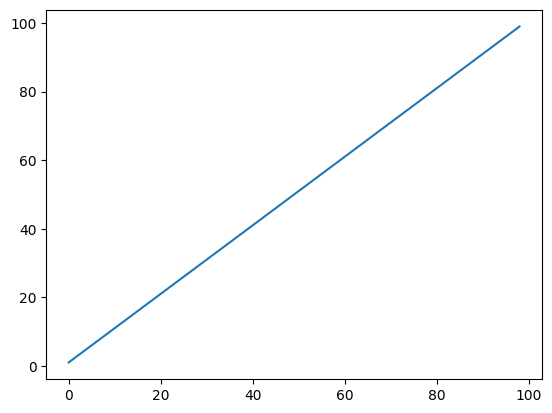

In [8]:
plt.plot(np.arange(1,100))

In [8]:
%cd /home/kevin/disk-d/dev/NewTranAD
!pwd

/home/kevin/disk-d/dev/NewTranAD
/home/kevin/disk-d/dev/NewTranAD


In [9]:
dataset_folder = 'data/addr1394'
SRC = False #16进制
df_dst_src = pd.read_csv(os.path.join(dataset_folder,"channels_1394_DST.csv"))#目的
df_id_src = pd.read_csv(os.path.join(dataset_folder,"channels_1394_ID.csv"))   
df_comb_src = pd.concat([df_dst_src, df_id_src], axis=1) if SRC else channel
print(df_comb_src.info(),df_comb_src.shape,df_comb_src.describe(include='all'))
df_comb_src.head(200)

NameError: name 'channel' is not defined

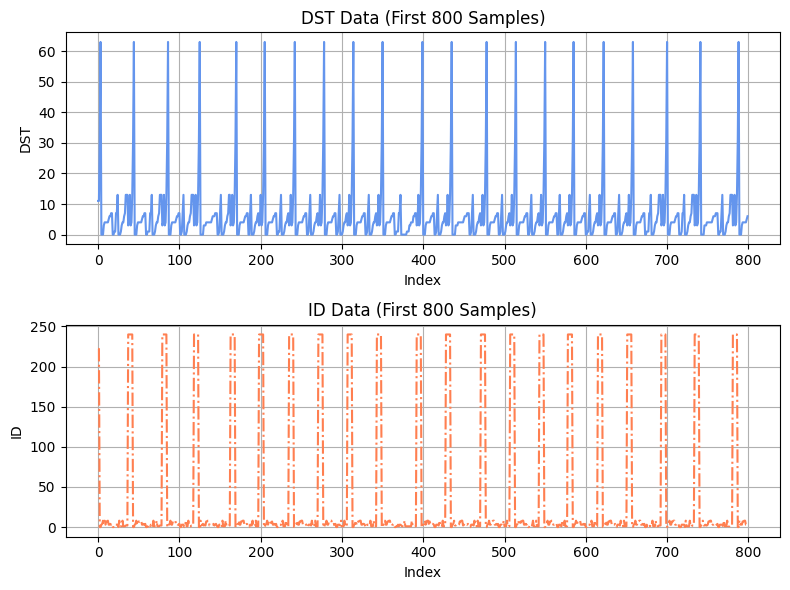

In [36]:
import matplotlib.pyplot as plt

NUMS = 800
# Select the first 500 rows of data
data_subset = df_comb_src.head(NUMS)

# Create a figure and axes objects
fig, axs = plt.subplots(2, figsize=(8, 6))

# Plot DST data on the first subplot (top)
axs[0].plot(data_subset.index, data_subset['DST'], linewidth=1.5, color='cornflowerblue')
axs[0].set_title(f'DST Data (First {NUMS} Samples)')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('DST')
axs[0].grid(True)

# Plot ID data on the second subplot (bottom)
axs[1].plot(data_subset.index, data_subset['ID'], linewidth=1.5, color='coral', linestyle='-.')
axs[1].set_title(f'ID Data (First {NUMS} Samples)')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('ID')
axs[1].grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig("preplot.svg")
plt.show()

In [20]:
df_comb_src.DST.unique()

array(['0B', '1F', '3F', '00', '03', '04', '05', '06', '07', '01', '0D',
       '02', '08'], dtype=object)

In [10]:
dataset_folder = 'data/addr1394'
features_num = FEATURES_NUM #<arg>
#~Read channel data (address)
# 1394 protocal
df_dst = pd.read_csv(os.path.join(dataset_folder,"channels_1394_DST.csv"))#目的
df_id = pd.read_csv(os.path.join(dataset_folder,"channels_1394_ID.csv"))   
df_comb = pd.concat([df_dst, df_id], axis=1)
channel = df_comb.apply(lambda x: x.astype(str).map(lambda x: int(x, base=16)))
        
# channel = pd.read_csv(os.path.join(dataset_folder,'channel.csv'), header=None)
# channel = channel.apply(lambda x: x.astype(str).map(lambda x: int(x, base=16))
# channel = channel.astype(float)
        
#~Normalization
range_n = RANGE_N #<arg>
xc = channel.values[:range_n] #[0:8000] #[0:5000] #[0:3000] #[0:2000]  # [0:1500
if DEBUG:
    print("xc: ", xc.shape)
print("xc: ", xc.shape)
xc_ref = ray.put(xc)

xc:  (2000, 2)
xc:  (2000, 2)


In [11]:
# test
[a,b,c] = [1, 2, 3]
print(b)

2


In [11]:
#TODO: test linear/non-linear scaler
@ray.remote(num_gpus=1)
def norm_data(xc):
    xc_scaled = preprocessing.MinMaxScaler().fit_transform(xc) #!!
    xc_log2 = np.log2(xc_scaled + 1) #!!
    xc_sin = np.sin(xc_scaled * np.pi) #TODO: maybe (1/2)*pi?
    xc_std = preprocessing.StandardScaler().fit_transform(xc_scaled) #!!
    xc_std_scaled = preprocessing.MinMaxScaler().fit_transform(xc_std)
    xc_std_log2 = np.log2(np.array([n if n.all() != 0 else n + EPS for n in xc_std_scaled])+1)
    xc_std_sin = np.sin(xc_std_scaled * np.pi) #TODO: maybe (1/2)*pi?
    xc_std_log2_sin = np.sin(xc_std_log2 * np.pi) #TODO: maybe (1/2)*pi?
    xc_l1 = preprocessing.normalize(xc, norm='l1') #!!
    xc_l2 = preprocessing.normalize(xc, norm='l2') #!!
    return [xc_scaled, xc_log2, xc_sin, xc_std, xc_std_scaled, xc_std_log2, xc_std_sin, xc_std_log2_sin, xc_l1 , xc_l2]
[xc_scaled, xc_log2, xc_sin, xc_std, xc_std_scaled, xc_std_log2, xc_std_sin, xc_std_log2_sin, xc_l1 , xc_l2] = ray.get(norm_data.remote(xc_ref))

In [12]:
SCALER_SUFFIX = ['_scaled', '_log2', '_sin', '_std', '_std_scaled', '_std_log2', '_std_sin', '_std_log2_sin', '_l1', '_l2']
SCALED_DATA = ['xc_scaled', 'xc_log2', 'xc_sin', 'xc_std', 'xc_std_scaled', 'xc_std_log2', 'xc_std_sin','xc_std_log2_sin', 'xc_l1', 'xc_l2']
SCALER_SUFFIX.insert(0, '') #origin
SCALED_DATA.insert(0,'xc')

In [34]:
a = ['a','b','c']
a.insert(0,'x')
a

['x', 'a', 'b', 'c']

(2000, 2)
['xc', 'xc_scaled', 'xc_log2', 'xc_sin', 'xc_std', 'xc_std_scaled', 'xc_std_log2', 'xc_std_sin', 'xc_std_log2_sin', 'xc_l1', 'xc_l2']
0 xc
1 xc_scaled
2 xc_log2
3 xc_sin
4 xc_std
5 xc_std_scaled
6 xc_std_log2
7 xc_std_sin
8 xc_std_log2_sin
9 xc_l1
10 xc_l2


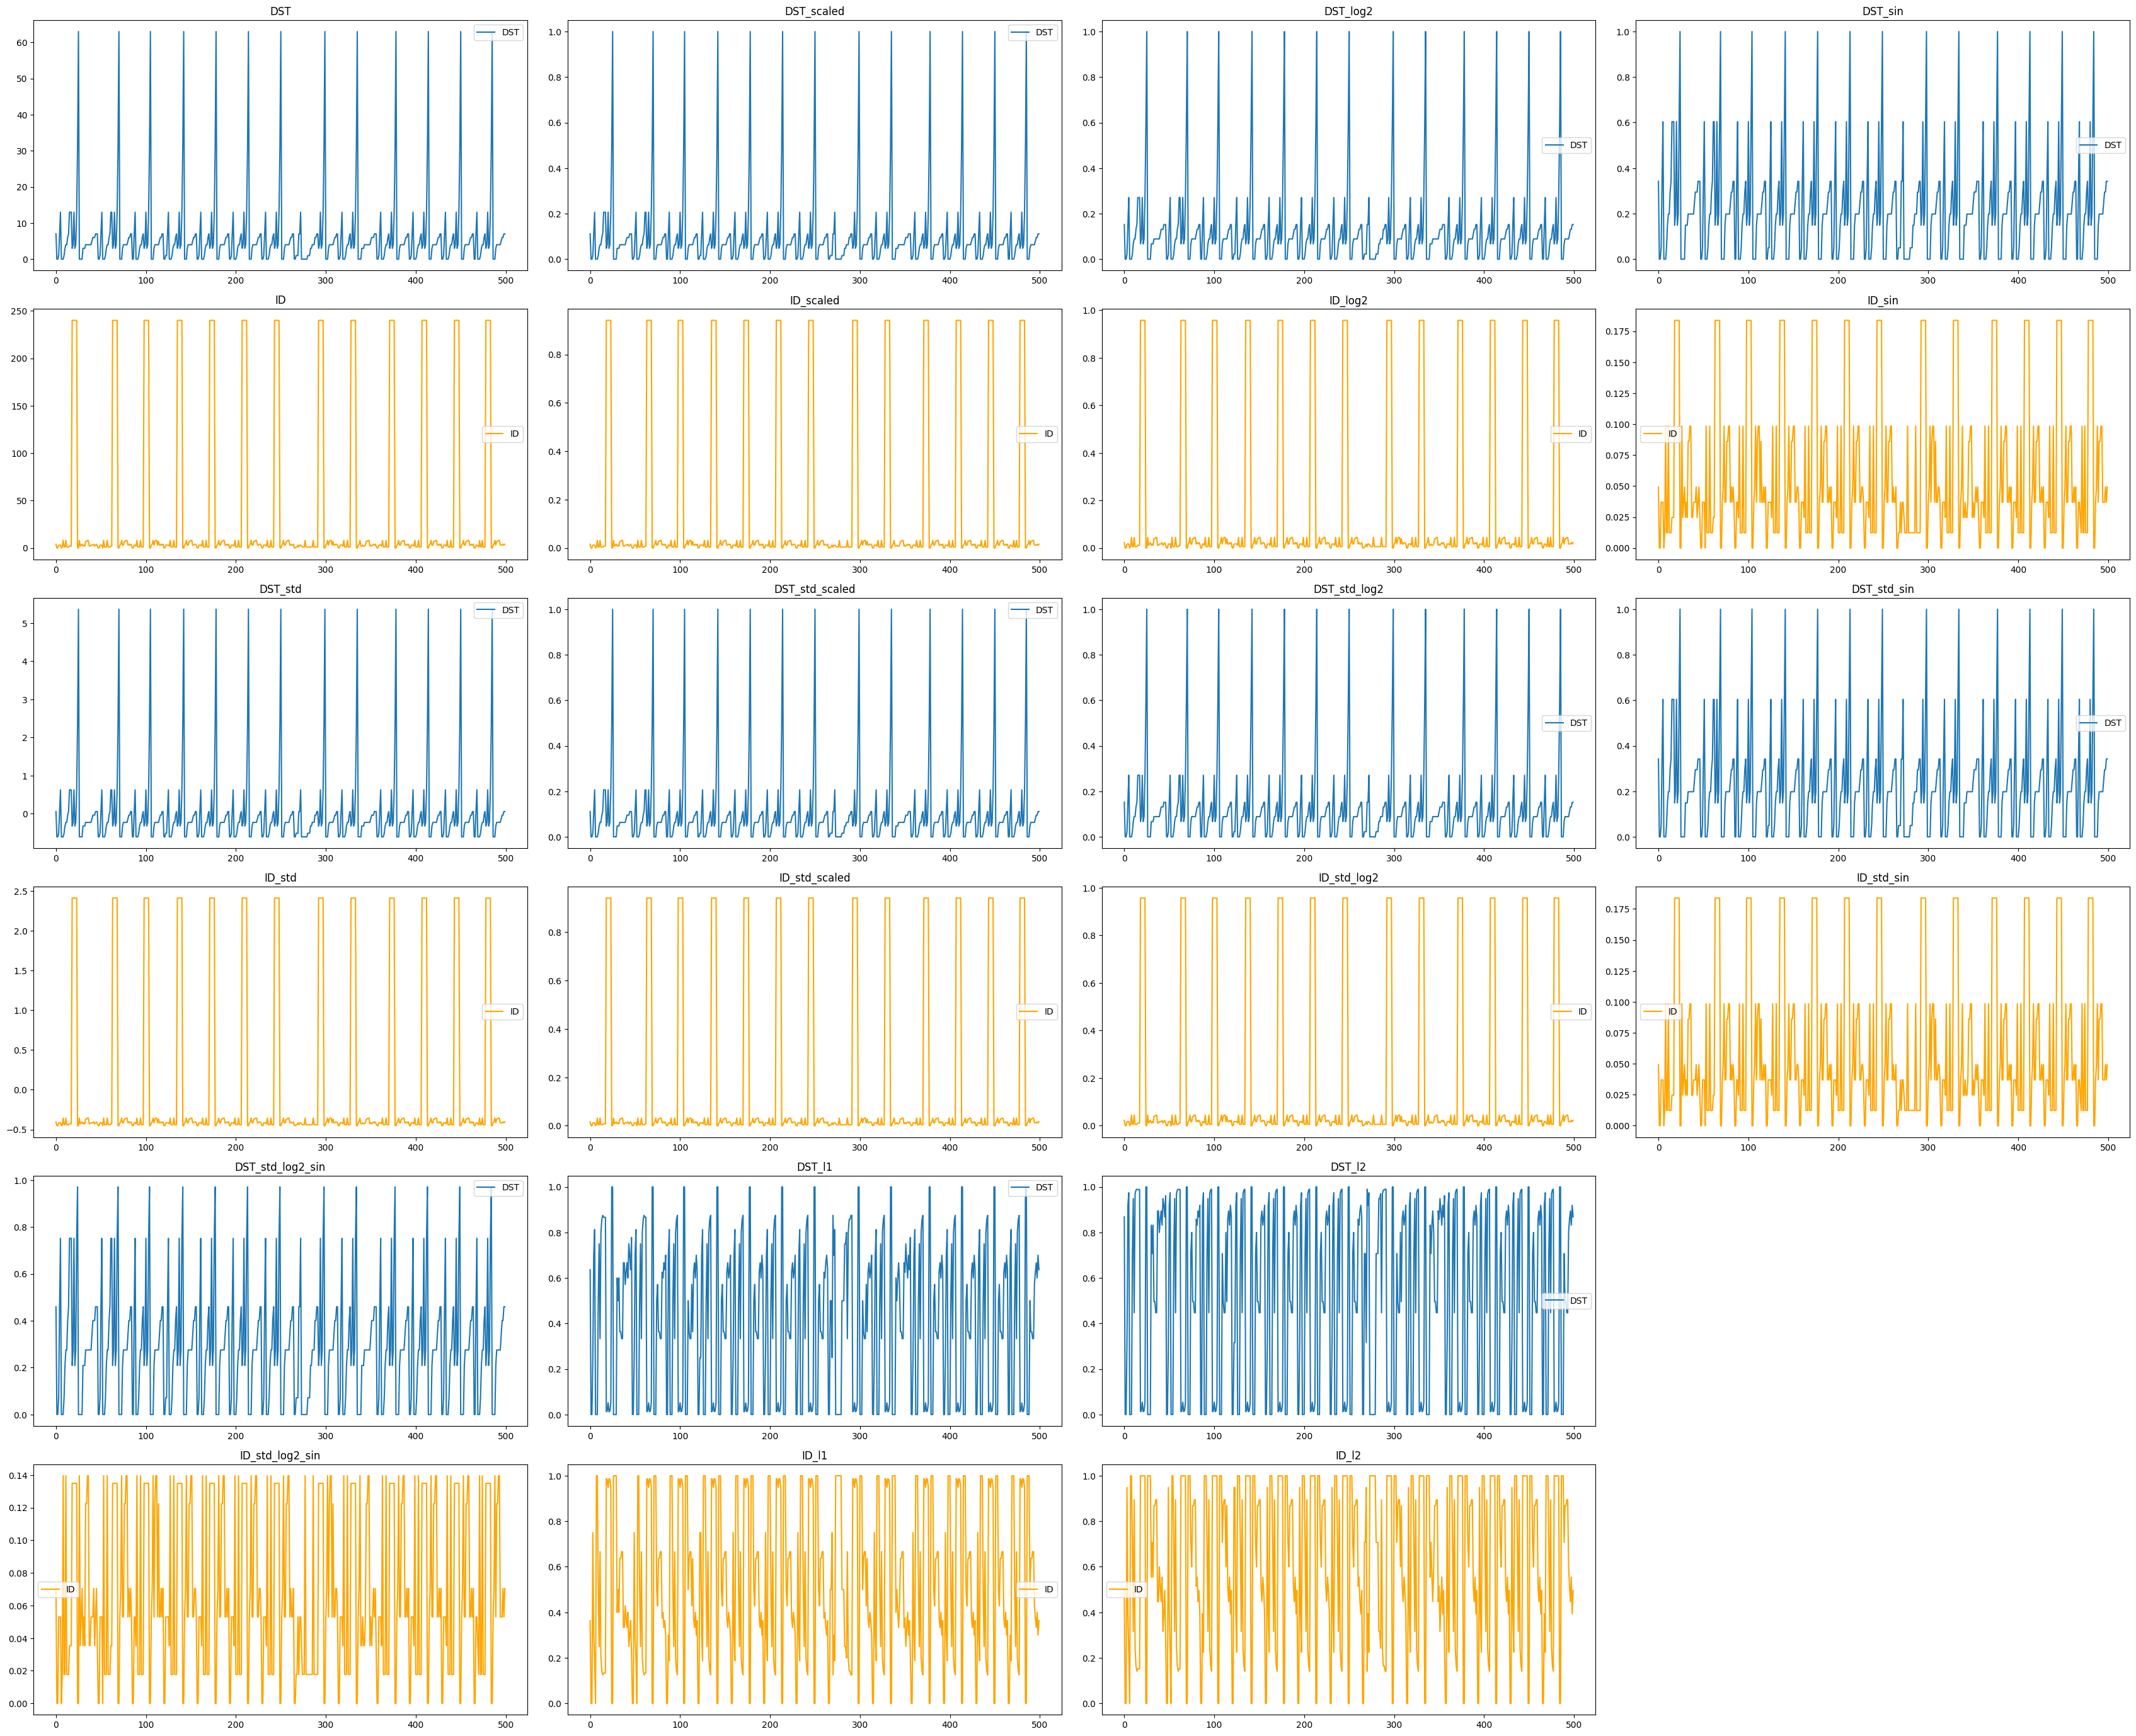

In [16]:
DEBUG_PLOT_RANGE_BEGIN = 100
DEBUG_PLOT_RANGE_END = 600
DEBUG = True

plt.close()
name = "all"
fig = plt.figure(figsize=(34, 32))
# fig.suptitle(f'Normalization Results - {name}', fontsize=16)

gs = fig.add_gridspec(7, 4)
if DEBUG:
    print(np.array(xc_scaled).shape)

    print(SCALED_DATA)
    # Plotting
    # 绘制每个序列的上下两张图
    for i, data in enumerate(SCALED_DATA):
        # plt.subplot(3, 4, i + 1)
        # plt.plot(data[:DEBUG_PLOT_RANGE, 0], label='DST')  # 绘制第一个子序列
        # plt.plot(data[:DEBUG_PLOT_RANGE, 1], label='ID')  # 绘制第二个子序列
        # plt.title('xc{0}'.format(SCALER_SUFFIX[i-1] if i >= 1 else ''))  # 设置子图标题为label
        # plt.legend()
        print(i,data)
        data = eval(data)
        row = i // 4
        col = i % 4
        
        ax_upper = plt.subplot(gs[2*row, col])
        ax_upper.plot(data[DEBUG_PLOT_RANGE_BEGIN:DEBUG_PLOT_RANGE_END, 0], label='DST')  # 绘制第一个子序列的上半部分
        ax_upper.set_title(f'DST{SCALER_SUFFIX[i]}')  # 设置子图标题为Upper Sequence - label i
        ax_upper.legend()
    
        ax_lower = plt.subplot(gs[2*row+1, col], sharex=ax_upper)
        ax_lower.plot(data[DEBUG_PLOT_RANGE_BEGIN:DEBUG_PLOT_RANGE_END, 1], label='ID', c='orange')  # 绘制第二个子序列的下半部分
        ax_lower.set_title(f'ID{SCALER_SUFFIX[i]}')  # 设置子图标题为Lower Sequence - label i
        ax_lower.legend()
    
    plt.tight_layout()
    plt.savefig("allnorms.svg")
    plt.show()
# for name, xc_scaled in zip(SCALER_SUFFIX, map(eval, SCALED_DATA)):
#     if DEBUG:
#         print(xc_scaled.shape)
#         plt.plot(xc[:DEBUG_PLOT_RANGE], label='xc'+name)
#         plt.plot(xc_scaled[:DEBUG_PLOT_RANGE], label='xc_scaled'+name)
#         plt.legend()
#         plt.show()
#     ##
#     test_num = TEST_NUM#<arg>
#     # split_ratio = SPLIT_RATIO #0.7 #0.5 #<arg>
#     # xc_scaled = channel.values# !!
#     # tc = xc_scaled[int(len(xc) * split_ratio):]
#     # xc = xc_scaled[:int(len(xc) * split_ratio)]
#     tc = xc_scaled[-test_num:]
#     xc = xc_scaled[:-test_num]
#     print("train"+name+" shape:", xc.shape)
#     print("test"+name+" shape:", tc.shape)
#     if DEBUG:
#         # plt.plot(xc[0:500])
#         # plt.plot(tc[0:500])
#         # plt.show()
#         plt.plot(tc[:1000], label='tc'+name)
#         # plt.plot(tc_scaled[:1000], label='tc_s')
#         plt.legend()
#         plt.show()
#     ##
#     #Label generatoin for tc
#     disturb_scale = DISTURB_SCALE #255 #0.25 #<arg>
#     disturb_probability = DISTURB_PROBABILITY #0.05 0.02 #<arg> 0.01
#     disturb_n_threshold_min = DISTURB_N_THRESHOLD_MIN #0.2 <arg>
#     disturb_n_threshold_max = DISTURB_N_THRESHOLD_MAX #0.8 #<arg>
#     error_split_probablity = ERROR_SPLIT_PROBABLITY #<arg>
#     # dd = 1
#     disturbc = []
#     labelsc = np.zeros_like(tc)
#     ttc = tc.copy()
#     np.random.seed(RANDOM_SEED) #<arg>
#     for i,t in enumerate(tc):
#         if np.random.rand(1)[0] < disturb_probability:
#         # if np.random.randn(1)[0] > 2.1: # disturb_probability:
#             # if np.random.rand(1)[0] < error_split_probablity or i == 0 or i ==
#             # add disturb
#             d = disturb_scale * np.random.random(1)[0]
#             while abs(d) < disturb_n_threshold_min or abs(d) > disturb_n_thresho
#                 d = disturb_scale * np.random.random(1)[0] #disturb_scale * np.a
#             ttc[:,0][i] += d  #TODO: disturb_scale
#             ttc[:,0][i] = abs(ttc[:,0][i])
#             # d = disturb_scale * np.random.randn(1)[0]
#             # while d < disturb_n_threshold_min or d > disturb_n_threshold_max o
#             #     d = disturb_scale * np.random.randn(1)[0]
#             # ttc[i] = d
#             # labelsc.append(np.array([1.0, 0.0])) #1 # abnormal
#             # print(ttc[i])
#             labelsc[i,0] = 1.0 #False #1 # abnormal [-TODO](+DONE:shift USAD and
#             disturbc.append(d)
#             # else:
#             #     # swap error
#             #     temp = tc[i + 1]
#             #     tc[i + 1] = tc[i]
#             #     tc[i] = temp
#             #     labelsc.append(np.array([1.0]))
#         else:
#             #labelsc.append(np.array([0.0])) #0#[-TODO](+DONE:shift USAD and Tra
#             disturbc.append(0.0)#[-TODO](+DONE:shift USAD and TrainAD output)：c
#     # print(labelsc[:200])
#     # channel = pd.DataFrame(xc)
#     # channel_ano = pd.DataFrame(tc)
#     # print(channel.shape, channel_ano.shape)
#     # channel.head(20)
#     # channel_ano.head(50)
#     if DEBUG:
#         plt.figure(figsize=(12, 8))
#         # Plot disturb
#         plt.subplot(411)
#         plt.plot(disturbc, label='disturb', linewidth=2, alpha=0.7)
#         plt.legend()
#         # Plot ttc
#         plt.subplot(412)
#         plt.plot(np.array(ttc), label='ttc'+name, linewidth=2, alpha=0.7)
#         plt.legend()
#         # Plot vari
#         plt.subplot(413)
#         plt.plot(np.array(ttc) - np.array(tc), label='vari', linewidth=2, alpha=
#         plt.legend()
#         plt.subplot(414)
#         plt.plot(labelsc, label='labels')
#         plt.legend()
#         plt.show()
#     ###
#     #################################################
#     # train, min_a, max_a = normalize2(xc)
#     # test, _, _ = normalize2(tc, min_a, max_a)
#     train = np.array(xc).reshape((-1,features_num))#TODO：comment for test
#     test = np.array(ttc).reshape((-1,features_num))#TODO：comment for test
#     labels = np.array(labelsc, dtype=float).reshape((-1,features_num)) #pd.read_
#     for file in ['train', 'test', 'labels']:
#         np.save(os.path.join(folder, f'{file+name}.npy'), eval(file))

lag1 =  0.72


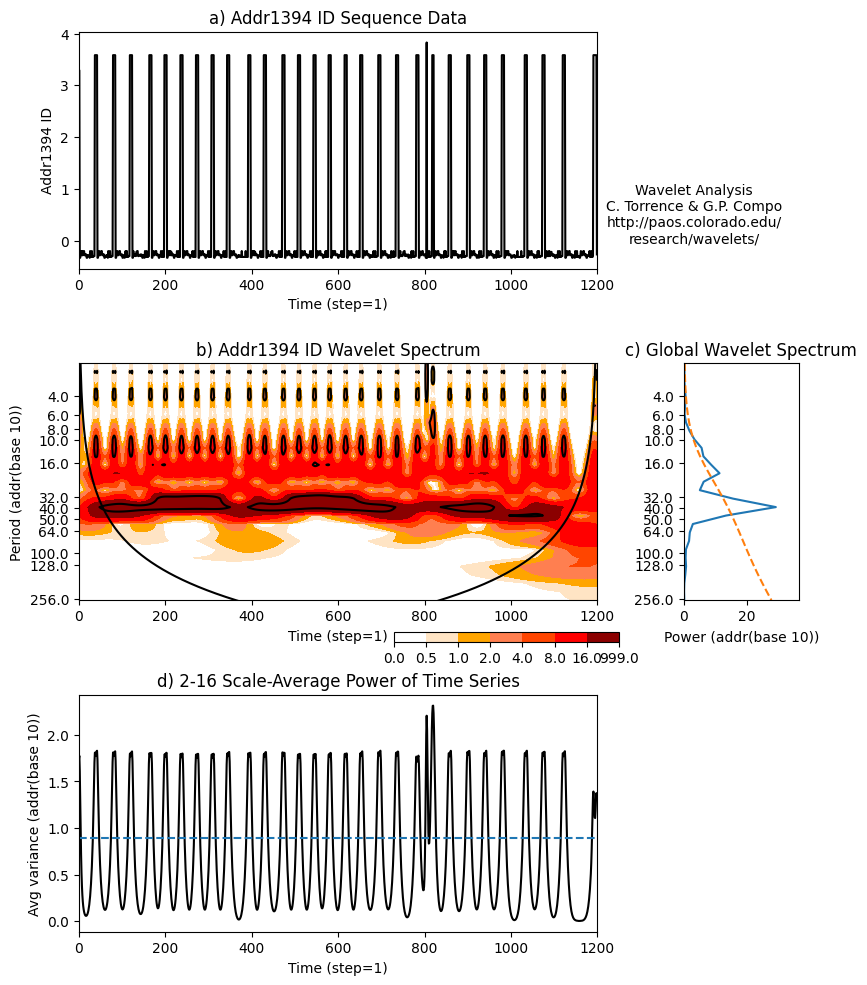

In [42]:
import numpy as np
from waveletFunctions import wavelet, wave_signif
import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

__author__ = 'Evgeniya Predybaylo'


# WAVETEST Example Python script for WAVELET, using NINO3 SST dataset
#
# See "http://paos.colorado.edu/research/wavelets/"
# The Matlab code written January 1998 by C. Torrence is modified to Python by Evgeniya Predybaylo, December 2014
#
# Modified Oct 1999, changed Global Wavelet Spectrum (GWS) to be sideways,
#   changed all "log" to "log2", changed logarithmic axis on GWS to
#   a normal axis.
# ------------------------------------------------------------------------------------------------------------------

# # READ THE DATA
# sst = np.loadtxt('sst_nino3.dat')  # input SST time series
# sst = sst - np.mean(sst)
# variance = np.std(sst, ddof=1) ** 2
# print("variance = ", variance)

#----------C-O-M-P-U-T-A-T-I-O-N------S-T-A-R-T-S------H-E-R-E------------------------------------------------------

# normalize by standard deviation (not necessary, but makes it easier
# to compare with plot on Interactive Wavelet page, at
# "http://paos.colorado.edu/research/wavelets/plot/"
col_name = 'ID'
RANGEE=1200
sst = xc_std[:RANGEE,0] if col_name=='DST' else xc_std[:RANGEE,1] ##TODO: 0:DST 1:ID
variance = np.std(sst, ddof=0) ** 2
n = len(sst)
dt = 1 #0.2 #0.5
time = np.arange(len(sst)) * dt  # construct time array
xlim = ([0, RANGEE])  # plotting range
pad = 1  # pad the time series with zeroes (recommended)
dj = 0.25  # this will do 4 sub-octaves per octave
s0 = 2 * dt  # this says start at a scale of 6 months
j1 = 7 / dj  # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72  # lag-1 autocorrelation for red noise background
print("lag1 = ", lag1)
mother = 'MORLET'

titlea = f'Addr1394 {col_name} Sequence Data'
titleb = f'Addr1394 {col_name} Wavelet Spectrum'
label = f'Addr1394 {col_name}'
units = 'addr(base 10)'

# Wavelet transform:
wave, period, scale, coi = wavelet(sst, dt, pad, dj, s0, j1, mother)
power = (np.abs(wave)) ** 2  # compute wavelet power spectrum
global_ws = (np.sum(power, axis=1) / n)  # time-average over all times

# Significance levels:
signif = wave_signif(([variance]), dt=dt, sigtest=0, scale=scale,
    lag1=lag1, mother=mother)
sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])  # expand signif --> (J+1)x(N) array
sig95 = power / sig95  # where ratio > 1, power is significant

# Global wavelet spectrum & significance levels:
dof = n - scale  # the -scale corrects for padding at edges
global_signif = wave_signif(variance, dt=dt, scale=scale, sigtest=1,
    lag1=lag1, dof=dof, mother=mother)

# Scale-average between El Nino periods of 2--8 years
avg = np.logical_and(scale >= 2, scale < 16) #(scale >= 32, scale < 50)#
Cdelta = 0.776  # this is for the MORLET wavelet
scale_avg = scale[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])  # expand scale --> (J+1)x(N) array
scale_avg = power / scale_avg  # [Eqn(24)]
scale_avg = dj * dt / Cdelta * sum(scale_avg[avg, :])  # [Eqn(24)]
scaleavg_signif = wave_signif(variance, dt=dt, scale=scale, sigtest=2,
    lag1=lag1, dof=([2, 7.9]), mother=mother)

#------------------------------------------------------ Plotting

#--- Plot time series
fig = plt.figure(figsize=(9, 10))
gs = GridSpec(3, 4, hspace=0.4, wspace=0.75)
plt.subplots_adjust(left=0.1, bottom=0.05, right=0.9, top=0.95, wspace=0, hspace=0)
plt.subplot(gs[0, 0:3])
plt.plot(time, sst, 'k')
plt.xlim(xlim[:])
plt.xlabel('Time (step=1)')
plt.ylabel(f'{label}')
plt.title(f'a) {titlea}')

plt.text(time[-1] + 225, 0.5,'Wavelet Analysis\nC. Torrence & G.P. Compo\n' +
    'http://paos.colorado.edu/\nresearch/wavelets/',
    horizontalalignment='center', verticalalignment='center')

#--- Contour plot wavelet power spectrum
# plt3 = plt.subplot(3, 1, 2)
plt3 = plt.subplot(gs[1, 0:3])
levels = [0, 0.5, 1, 2, 4, 8,16, 999]
CS = plt.contourf(time, period, power, len(levels))  #*** or use 'contour'
im = plt.contourf(CS, levels=levels, colors=['white','bisque','orange','coral','orangered','red','darkred'])
plt.xlabel('Time (step=1)')
plt.ylabel(f'Period ({units})')
plt.title(f'b) {titleb}') #(contours at 0.5,1,2,4\u00B0C$^2$)')
plt.xlim(xlim[:])
# 95# significance contour, levels at -99 (fake) and 1 (95# signif)
plt.contour(time, period, sig95, [-99, 1], colors='k')
# cone-of-influence, anything "below" is dubious
plt.plot(time, coi, 'k')
# format y-scale
plt3.set_yscale('log', base=2)
plt3.set_yticks([0,0.25,1,2,4,6,8,10,16,32,40,50,64,100,128,256], labels=['0','0.25','1','2','4','6','8','10','16','32','40','50','64','100','128','256'])
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt3.ticklabel_format(axis='y', style='plain')
plt3.invert_yaxis()
# set up the size and location of the colorbar
position=fig.add_axes([0.45,0.34,0.25,0.01]) 
plt.colorbar(im,cax=position,orientation='horizontal') #,, , fraction=0.05, pad=0.5, orientation='horizontal')

# plt.subplots_adjust(right=0.7, top=0.9)

#--- Plot global wavelet spectrum
plt4 = plt.subplot(gs[1, -1])
plt.plot(global_ws, period)
plt.plot(global_signif, period, '--')
plt.xlabel(f'Power ({units})')
plt.title('c) Global Wavelet Spectrum')
plt.xlim([0, 1.25 * np.max(global_ws)])
# format y-scale
plt4.set_yscale('log', base=2)
plt4.set_yticks([0,0.25,1,2,4,6,8,10,16,32,40,50,64,100,128,256], labels=['0','0.25','1','2','4','6','8','10','16','32','40','50','64','100','128','256'])
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt4.ticklabel_format(axis='y', style='plain')
plt4.invert_yaxis()

# --- Plot 2--8 yr scale-average time series
plt.subplot(gs[2, 0:3])
plt.plot(time, scale_avg, 'k')
plt.xlim(xlim[:])
plt.xlabel('Time (step=1)')
plt.ylabel(f'Avg variance ({units})')
plt.title('d) 2-16 Scale-Average Power of Time Series')
plt.plot(xlim, scaleavg_signif + [0, 0], '--')


res = plt.savefig(f"wlspec-{col_name}.svg")
plt.show()
res
# end of code

In [79]:
!pwd

/home/kevin/disk-d/dev/NewTranAD


In [49]:
#deprecated
# from __future__ import division
# import numpy
# from matplotlib import pyplot as plt

# import pycwt as wavelet
# from pycwt.helpers import find

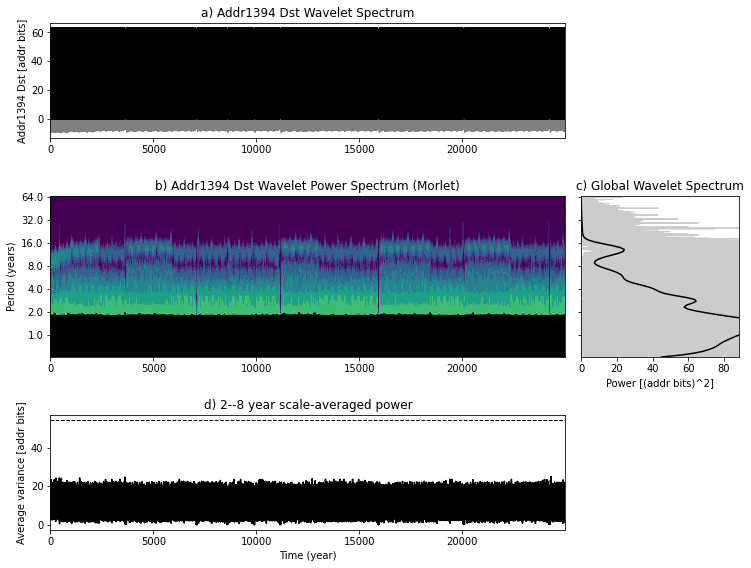

In [52]:
#deprecated
# dat = xc[:,0]
# title = 'Addr1394 Dst Wavelet Spectrum'
# label = 'Addr1394 Dst'
# units = 'addr bits'

# N = len(dat)
# dt = 0.25
# t0 = 0
# t = np.arange(0, N) * dt
# p = np.polyfit(t - t0, dat, 1)
# dat_notrend = dat - np.polyval(p, t - t0)
# std = dat_notrend.std()  # Standard deviation
# var = std ** 2  # Variance
# dat_norm = dat_notrend / std  # Normalized dataset

# mother = wavelet.Morlet(6)
# s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
# dj = 1 / 12  # Twelve sub-octaves per octaves
# J = 7 / dj  # Seven powers of two with dj sub-octaves
# alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

# wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
#                                                       mother)
# iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

# power = (np.abs(wave)) ** 2
# fft_power = np.abs(fft) ** 2
# period = 1 / freqs

# power /= scales[:, None]

# signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
#                                          significance_level=0.95,
#                                          wavelet=mother)
# sig95 = numpy.ones([1, N]) * signif[:, None]
# sig95 = power / sig95

# glbl_power = power.mean(axis=1)
# dof = N - scales  # Correction for padding at edges
# glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
#                                         significance_level=0.95, dof=dof,
#                                         wavelet=mother)

# sel = find((period >= 2) & (period < 8))
# Cdelta = mother.cdelta
# scale_avg = (scales * numpy.ones((N, 1))).transpose()
# scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
# scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
# scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
#                                              significance_level=0.95,
#                                              dof=[scales[sel[0]],
#                                                   scales[sel[-1]]],
#                                              wavelet=mother)

# # Prepare the figure
# plt.close('all')
# plt.ioff()
# figprops = dict(figsize=(11, 8), dpi=72)
# fig = plt.figure(**figprops)

# # First sub-plot, the original time series anomaly and inverse wavelet
# # transform.
# ax = plt.axes([0.1, 0.75, 0.65, 0.2])
# ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# ax.plot(t, dat, 'k', linewidth=1.5)
# ax.set_title('a) {}'.format(title))
# ax.set_ylabel(r'{} [{}]'.format(label, units))

# # Second sub-plot, the normalized wavelet power spectrum and significance
# # level contour lines and cone of influece hatched area. Note that period
# # scale is logarithmic.
# bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
# levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
# bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
#             extend='both', cmap=plt.cm.viridis)
# extent = [t.min(), t.max(), 0, max(period)]
# bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#            extent=extent)
# bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
#                            t[:1] - dt, t[:1] - dt]),
#         numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
#                            numpy.log2(period[-1:]), [1e-9]]),
#         'k', alpha=0.3, hatch='x')
# bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
# bx.set_ylabel('Period (years)')
# #
# Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
#                            numpy.ceil(numpy.log2(period.max())))
# bx.set_yticks(numpy.log2(Yticks))
# bx.set_yticklabels(Yticks)

# # Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# # noise spectra. Note that period scale is logarithmic.
# cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
# cx.plot(glbl_signif, numpy.log2(period), 'k--')
# cx.plot(var * fft_theor, numpy.log2(period), '--', color='#cccccc')
# cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
#         linewidth=1.)
# cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
# cx.set_title('c) Global Wavelet Spectrum')
# cx.set_xlabel(r'Power [({})^2]'.format(units))
# cx.set_xlim([0, glbl_power.max() + var])
# cx.set_ylim(numpy.log2([period.min(), period.max()]))
# cx.set_yticks(numpy.log2(Yticks))
# cx.set_yticklabels(Yticks)
# plt.setp(cx.get_yticklabels(), visible=False)

# # Fourth sub-plot, the scale averaged wavelet spectrum.
# dx = plt.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
# dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
# dx.plot(t, scale_avg, 'k-', linewidth=1.5)
# dx.set_title('d) {}--{} year scale-averaged power'.format(2, 8))
# dx.set_xlabel('Time (year)')
# dx.set_ylabel(r'Average variance [{}]'.format(units))
# ax.set_xlim([t.min(), t.max()])

# plt.show()